<a href="https://colab.research.google.com/github/rajesh0305/Image-Processing-And-Computer-Vision-/blob/main/Transfer_Learning_without_Fine_Tuning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import wandb
from wandb.integration.keras import WandbMetricsLogger

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [6]:
# Sweep configuration
sweep_config = {
    'method': 'grid',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'batch_size': {'values': [8]},
        'learning_rate': {'values': [0.0001]},
        'img_size': {'values': [128]},  # Set a reasonably large size for MobileNetV2
        'epochs': {'values': [20]},
        'experiment': {'values': ['transfer_learning']}
    }
}

In [7]:
# Initialize W&B sweep
sweep_id = wandb.sweep(sweep_config, project="5-flowers-transfer-learning")

Create sweep with ID: 8i4akps3
Sweep URL: https://wandb.ai/rajesh8368568776-national-institute-of-technology-karnat/5-flowers-transfer-learning/sweeps/8i4akps3


# MobileNetV2 Model
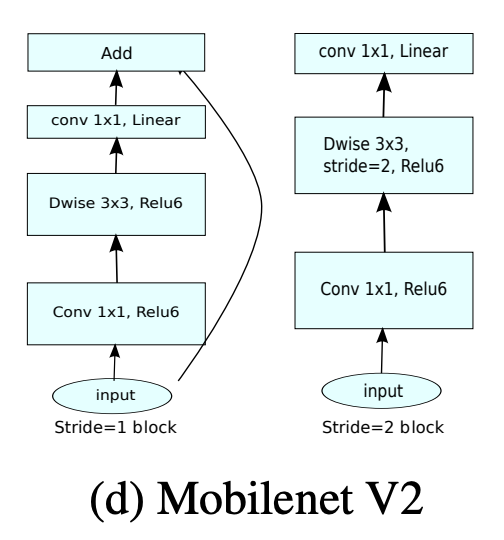


In [8]:
# Train function
def train():
    with wandb.init() as run:
        config = wandb.config

        IMG_HEIGHT = config.img_size
        IMG_WIDTH = config.img_size
        IMG_CHANNELS = 3
        CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

        # Helper functions
        def read_and_decode(filename, resize_dims):
            img_bytes = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, resize_dims)
            return img

        def parse_csvline(csv_line):
            record_default = ["", ""]
            filename, label_string = tf.io.decode_csv(csv_line, record_default)
            img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
            label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
            return img, label

        # Prepare datasets
        train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        eval_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(config.batch_size)
            .prefetch(tf.data.AUTOTUNE)
        )

        # Build model
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            include_top=False,    # Remove ImageNet head
            weights="imagenet"    # Use pretrained weights
        )
        base_model.trainable = False  # Freeze base

        model = keras.Sequential([
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.BatchNormalization(),       # Add BatchNorm
            keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
        ])

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )

        # Visualize model
        model.summary()

        keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_visualization.png")

        # Train
        callbacks = [WandbMetricsLogger(log_freq=5)]

        model.fit(
            train_dataset,
            validation_data=eval_dataset,
            epochs=config.epochs,
            callbacks=callbacks
        )

In [9]:
# Launch W&B agent
wandb.agent(sweep_id,function=train)

wandb: Agent Starting Run: keds8c6d with config:
wandb: 	batch_size: 8
wandb: 	epochs: 20
wandb: 	experiment: transfer_learning
wandb: 	img_size: 128
wandb: 	learning_rate: 0.0001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/20
    413/Unknown 89s 197ms/step - accuracy: 0.3755 - loss: 1.6702

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 107s 239ms/step - accuracy: 0.3758 - loss: 1.6694 - val_accuracy: 0.7108 - val_loss: 0.8520
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 127s 213ms/step - accuracy: 0.6845 - loss: 0.8414 - val_accuracy: 0.7784 - val_loss: 0.6320
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 88s 213ms/step - accuracy: 0.7553 - loss: 0.6654 - val_accuracy: 0.8108 - val_loss: 0.5438
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 138s 335ms/step - accuracy: 0.7952 - loss: 0.5790 - val_accuracy: 0.8162 - val_loss: 0.4971
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 81s 195ms/step - accuracy: 0.8159 - loss: 0.5221 - val_accuracy: 0.8270 - val_loss: 0.4680
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 80s 192ms/step - accuracy: 0.8327 - loss: 0.4791 - val_accuracy: 0.8270 - val_loss: 0.4483
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 84s 203ms/step - accuracy: 0.8444 - loss: 0.4443 - val_accuracy: 0.8405 - val_loss: 0.4340
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 83s 202ms/step - accuracy: 0.8526 - loss: 0.4149 - 

batch/accuracy,▁▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
batch/batch_step,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▅▄▄▄▄▄▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▆▆▆▇▇▇███████████
epoch/val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.93613


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


https://wandb.ai/rajesh8368568776-national-institute-of-technology-karnat/5-flowers-transfer-learning/reports/Untitled-Report--VmlldzoxNTI4NzQ0MA